In [6]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import backend as K

from scipy.sparse import csr_matrix, vstack, hstack
from sklearn.metrics import roc_auc_score

In [8]:
train = pd.read_csv("data/train.csv").dropna()
test = pd.read_csv("data/test.csv").dropna()
token_train = train['Text_unigram']
token_test = test['Text_unigram']
y_train = np.array(train['Sentiment'])
y_test = np.array(test['Sentiment'])
X_train = train.drop(['Sentiment', 'Text_unigram'], axis=1)
X_train = X_train.values
X_test = test.drop(['Sentiment', 'Text_unigram'], axis=1).values
gen_features = ['word_count', 'unigram_count', 'unique_word_count', 'unique_unigram_count', 'stopword_count', 'mean_word_length', 'mean_unigram_length', 'char_count', 'punctuation_count', 'number_count']

## Feed Forward Implementation

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.legacy import Adam

model = Sequential()
model.add(Dense(16, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=l2(0.0001))) #best 0.0001
model.add(Dense(24, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.008176190368614009))) #layers 16, 24, 16 based on keras tuner
model.add(Dense(1, activation='tanh'))  # Output layer


def custom_binary_crossentropy(y_true, y_pred):
    # Transform y_true to 0 and 1.
    y_true_transformed = K.cast((y_true + 1) / 2, dtype='float64')
    y_pred_transformed = K.cast((y_pred + 1) / 2, dtype='float64')

    # Compute binary crossentropy
    bce = K.binary_crossentropy(y_true_transformed, y_pred_transformed, from_logits=False)
    
    return K.mean(bce)

adam = Adam(learning_rate=0.0002)
def custom_accuracy(y_true, y_pred):
    # Since y_pred comes from tanh, values will be between -1 and 1.
    # We convert these to 1 and -1 for comparison.
    y_pred_labels = K.cast(K.greater(y_pred, 0), K.floatx()) * 2 - 1
    # Compare predicted labels to true labels
    correct_predictions = K.equal(y_true, y_pred_labels)
    # Calculate accuracy
    return K.mean(correct_predictions, axis=-1)

model.compile(optimizer=adam, loss=custom_binary_crossentropy, metrics=[custom_accuracy])
# Fit the model - assuming your data is ready and appropriately preprocessed
history = model.fit(X_train, y_train, epochs=1000, batch_size=8, validation_split=0.1)

Epoch 1/1000
663/663 [==============================] - 1s 745us/step - loss: 0.8919 - custom_accuracy: 0.5707 - val_loss: 0.8204 - val_custom_accuracy: 0.3203
Epoch 2/1000
663/663 [==============================] - 0s 622us/step - loss: 0.7346 - custom_accuracy: 0.5988 - val_loss: 1.0128 - val_custom_accuracy: 0.1068
Epoch 3/1000
663/663 [==============================] - 0s 604us/step - loss: 0.7105 - custom_accuracy: 0.6092 - val_loss: 0.7262 - val_custom_accuracy: 0.4237
Epoch 4/1000
663/663 [==============================] - 0s 609us/step - loss: 0.6932 - custom_accuracy: 0.6175 - val_loss: 0.7796 - val_custom_accuracy: 0.3237
Epoch 5/1000
663/663 [==============================] - 0s 599us/step - loss: 0.6741 - custom_accuracy: 0.6339 - val_loss: 0.8494 - val_custom_accuracy: 0.2983
Epoch 6/1000
663/663 [==============================] - 0s 654us/step - loss: 0.6468 - custom_accuracy: 0.6695 - val_loss: 0.6538 - val_custom_accuracy: 0.6186
Epoch 7/1000
663/663 [==================

In [46]:
from tensorflow.keras.models import load_model
#model.save('data/ffmodel') #save model
ffmodel = load_model('data/ffmodel', custom_objects={'custom_accuracy': custom_accuracy, 'custom_binary_crossentropy': custom_binary_crossentropy})
#history_df = pd.DataFrame(history.history)
#history_csv_file_path = 'data/ffmodel_training_history.csv'
#history_df.to_csv(history_csv_file_path, index=False)
ff_history_df = pd.read_csv('data/ffmodel_training_history.csv')

Hyperparameter Tuning

In [ ]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('layer1', min_value=8, max_value=64, step=8),
                    activation='relu', input_dim=X_train.shape[1],
                    kernel_regularizer=l2(hp.Float('l2_1', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
    #model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('layer2', min_value=8, max_value=32, step=8),
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('l2_2', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
    model.add(Dense(units=hp.Int('layer3', min_value=8, max_value=16, step=8),
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('l2_3', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
    # You can also add Dropout here if needed
    model.add(Dense(1, activation='tanh'))

    adam = Adam(learning_rate=hp.Float('learning_rate', min_value=0.00005, max_value=0.0002, step =0.00005))
    model.compile(optimizer=adam, loss=custom_binary_crossentropy, metrics=[custom_accuracy])

    return model

# Create a tuner
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("val_custom_accuracy", direction="max"),
    max_epochs=50,
    hyperband_iterations=2)

# Perform hyperparameter tuning
tuner.search(X_train, y_train, 
             epochs=50, validation_split=0.1, 
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


In [ ]:

# You can now access the best hyperparameters as follows:
best_layer1 = best_hps.get('layer1')
best_layer2 = best_hps.get('layer2')
best_layer3 = best_hps.get('layer3')
best_l2_1 = best_hps.get('l2_1')
best_l2_2 = best_hps.get('l2_2')
best_l2_3 = best_hps.get('l2_3')
best_learning_rate = best_hps.get('learning_rate')
print(best_hps.values)
# Now you can use these best hyperparameters to build the best model
best_model = tuner.hypermodel.build(best_hps)

# Summary of the best model
best_model.summary()

# You can now train the best model with the optimal hyperparameters
history = best_model.fit(X_train, y_train)

In [ ]:
y_pred_test = model.predict(X_test)
roc_auc_test = roc_auc_score(y_test, y_pred_test)
print(f'AUC: {roc_auc_test}')

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, TextVectorization
from tensorflow.keras.models import Model


# TextVectorization for comment and parent_comment
max_features = 6000 #follow number of tokens for feedforward


vectorize_layer_comment = TextVectorization(
    max_tokens=max_features,
    split='whitespace',
    ngrams=3
    )
# Prepare dataset for TextVectorization adapt
train_texts = token_train.tolist()
test_texts = token_test.tolist()
vectorize_layer_comment.adapt(train_texts)
# Prepare text inputs
train_texts = np.array(train_texts)[:, np.newaxis]
test_texts = np.array(test_texts)[:, np.newaxis]
#other inputs
train_other_features = np.array(train[gen_features]).astype(np.float32)
test_other_features = np.array(test[gen_features]).astype(np.float32)

In [21]:
from tensorflow.keras.layers import Embedding
#from tensorflow.keras.optimizers import Adam
#use tf.keras.optimizers.legacy.Adam if on M1/M2 macbook
# Assuming max_features is the vocabulary size and embedding_dim is the dimension of the embedding
embedding_dim = 128  # You can choose an appropriate value

# Add an Embedding layer after text vectorization
embedding_layer = Embedding(max_features, embedding_dim)

# LSTM Branch
text_input_comment = Input(shape=(1,), dtype=tf.string, name='text_comment')
text_features_comment = vectorize_layer_comment(text_input_comment)
text_features_comment = embedding_layer(text_features_comment)  # Embedding layer
lstm_comment = LSTM(16)(text_features_comment)

# Dense Features Branch
other_features_input = Input(shape=(len(gen_features),), name='other_features')
dense_features = Dense(24, activation='relu', kernel_regularizer=l2(0.0001))(other_features_input)

# Concatenate
concatenated = Concatenate()([lstm_comment, dense_features])

# Additional Dense Layers
output = Dense(16, activation='relu', kernel_regularizer=l2(0.0001))(concatenated)
output = Dense(1, activation='tanh')(output)

# Build Model
model = Model(inputs=[text_input_comment, other_features_input], outputs=output)
#optimiser = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)
# Compile
model.compile(optimizer="adam", loss=custom_binary_crossentropy, metrics=[custom_accuracy])#use Adam optimiser

In [23]:
# Fit the model
history = model.fit(
    [train_texts, train_other_features], y_train,
    epochs=15,
    batch_size=8,
    validation_split=0.2  # or use a validation set
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([test_texts, test_other_features], y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Predict probabilities for the test set
y_pred_probs = model.predict([test_texts, test_other_features]).ravel()

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"ROC-AUC Score: {roc_auc}")

Epoch 1/15
590/590 [==============================] - 6s 9ms/step - loss: 0.0247 - custom_accuracy: 0.9934 - val_loss: 0.0096 - val_custom_accuracy: 0.9983
Epoch 2/15
590/590 [==============================] - 5s 9ms/step - loss: 0.0194 - custom_accuracy: 0.9947 - val_loss: 0.0208 - val_custom_accuracy: 0.9941
Epoch 3/15
590/590 [==============================] - 5s 9ms/step - loss: 0.0199 - custom_accuracy: 0.9955 - val_loss: 0.0042 - val_custom_accuracy: 0.9992
Epoch 4/15
590/590 [==============================] - 5s 9ms/step - loss: 0.0158 - custom_accuracy: 0.9951 - val_loss: 0.0081 - val_custom_accuracy: 0.9983
Epoch 5/15
590/590 [==============================] - 5s 9ms/step - loss: 0.0123 - custom_accuracy: 0.9964 - val_loss: 0.0228 - val_custom_accuracy: 0.9958
Epoch 6/15
590/590 [==============================] - 5s 9ms/step - loss: 0.0142 - custom_accuracy: 0.9960 - val_loss: 0.0052 - val_custom_accuracy: 0.9983
Epoch 7/15
590/590 [==============================] - 5s 9ms/ste

In [37]:
from tensorflow.keras.models import load_model
#model.save('data/lstmmodel') #save model
lstmmodel = load_model('data/lstmmodel', custom_objects={'custom_accuracy': custom_accuracy, 'custom_binary_crossentropy': custom_binary_crossentropy})
#history_df = pd.DataFrame(history.history)
#history_csv_file_path = 'data/lstmmodel_training_history.csv'
#history_df.to_csv(history_csv_file_path, index=False)
lstm_history_df = pd.read_csv('data/lstmmodel_training_history.csv')

Performance Analysis

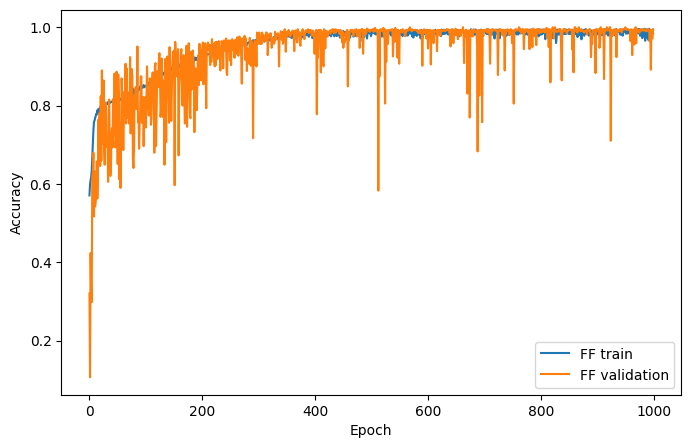

In [47]:
import matplotlib.pyplot as plt

#want to visialise the training history over epochs
plt.figure(figsize=(8, 5)) 
plt.plot(ff_history_df['custom_accuracy'], label='FF train')
plt.plot(ff_history_df['val_custom_accuracy'], label='FF validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Evident from 0.998 validation accuracy on epoch one, that there is some form of data leakage.

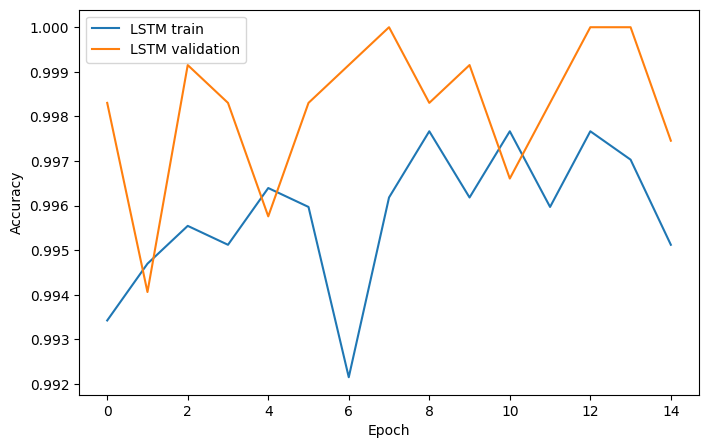

In [48]:
import matplotlib.pyplot as plt

#want to visialise the training history over epochs
plt.figure(figsize=(8, 5)) 
plt.plot(lstm_history_df['custom_accuracy'], label='LSTM train')
plt.plot(lstm_history_df['val_custom_accuracy'], label='LSTM validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

37/37 [==============================] - 0s 3ms/step - loss: 1.2413 - custom_accuracy: 0.7645
LSTM Model - Test Loss: 1.2412574291229248, Test Accuracy: 0.7644520998001099
37/37 [==============================] - 0s 379us/step
LSTM Model ROC-AUC Score: 0.8110512459043829
Feed-Forward Model ROC-AUC Score: 0.7675524142414821


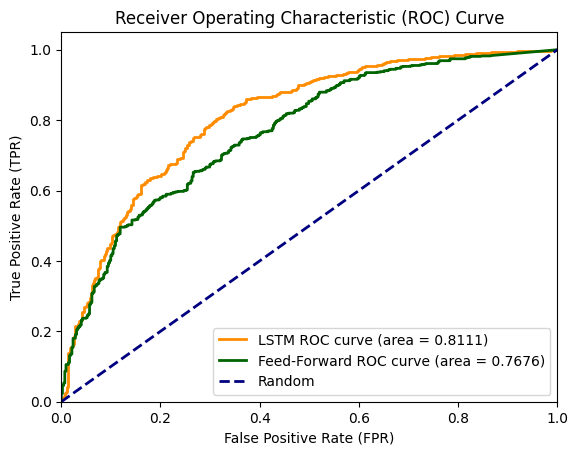

In [49]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Assuming 'lstmmodel' and 'ffmodel' are your trained Keras models
# Evaluate the LSTM model on the test set
test_loss, test_accuracy = lstmmodel.evaluate([test_texts, test_other_features], y_test)
print(f"LSTM Model - Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Predict probabilities for the test set
lstm_y_pred_probs = lstmmodel.predict([test_texts, test_other_features]).ravel()
ff_y_pred_probs = ffmodel.predict(X_test).ravel()

# Calculate ROC-AUC for both models
lstm_roc_auc = roc_auc_score(y_test, lstm_y_pred_probs)
ff_roc_auc = roc_auc_score(y_test, ff_y_pred_probs)
print(f"LSTM Model ROC-AUC Score: {lstm_roc_auc}")
print(f"Feed-Forward Model ROC-AUC Score: {ff_roc_auc}")

# Compute ROC curve and ROC area for both models
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_y_pred_probs)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

fpr_ff, tpr_ff, _ = roc_curve(y_test, ff_y_pred_probs)
roc_auc_ff = auc(fpr_ff, tpr_ff)

# Plot ROC curve for LSTM model
plt.figure()
plt.plot(fpr_lstm, tpr_lstm, color='darkorange', lw=2, label=f'LSTM ROC curve (area = {roc_auc_lstm:.4f})')

# Plot ROC curve for Feed-Forward model
plt.plot(fpr_ff, tpr_ff, color='darkgreen', lw=2, label=f'Feed-Forward ROC curve (area = {roc_auc_ff:.4f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

# Add labels and legend
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()